In [1]:
import os
import sys

# Importante, serve a fare in modo che il jupyter notebook possa vedere ed importare i file di libreria che creiamo in questa cartella.
sys.path.insert(0, '..')

In [2]:
# Pandas
import pandas as pd

# Valutatore del modello
import functions.evaluation as evaluation

# Funzioni di caricamento dati
import functions.load as load

# Modello
import lightgbm as lgb

In [3]:
# Carico il dataset
custom_df = pd.read_csv(r'../data/ridge_features_refined_data.csv')
custom_df.head()


,Lot_Area,Overall_Qual,Overall_Cond,Mas_Vnr_Area,Exter_Qual,Bsmt_Qual,Bsmt_Exposure,BsmtFin_Type_1,Bsmt_Unf_SF,Total_Bsmt_SF,...,Central_Air_N,Central_Air_Y,Garage_Type_Basment,Garage_Type_BuiltIn,Garage_Type_Detchd,Garage_Type_No_Garage,Sale_Type_'WD ',Year_Sold,Mo_Sold,Sale_Price
0,-2.125439,7,5,0.292336,3,4,3,6,0.799868,0.339314,...,0,1,0,0,0,0,0,2006,3,0.015387
1,-2.123480,7,5,1.114337,3,4,4,6,0.847019,0.412956,...,0,1,0,0,0,0,1,2006,4,0.614236
2,-2.007543,8,5,0.628858,3,4,4,1,0.817310,0.356023,...,0,1,0,0,0,0,1,2006,5,0.631522
3,-2.173043,7,5,0.628858,3,4,3,6,0.098655,0.416660,...,0,1,0,0,0,0,1,2006,5,0.971735
4,-2.085350,7,5,0.334853,3,4,1,1,0.858377,0.420960,...,0,1,0,0,0,0,1,2006,5,0.178497


In [4]:
# Crea il modello di LightGBM
model = lgb.LGBMRegressor(n_jobs=4,verbose=-1)

# Definisco gli iperparametri da esplorare
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 5, 10],
    'min_data_in_leaf': [20, 50, 100]
}


In [5]:
# Crea l'Evaluator per valutare il modello
ev = evaluation.Evaluator(model = model, df = custom_df, ylabel = 'Sale_Price')

In [6]:
# Trova quali sono i parametri migliori per il modello
best_params, best_score = ev.grid_search_cv(params=param_grid)
load.saveBestParameterModel(type(ev.model).__name__,best_params)

best_params, best_score

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min

({'learning_rate': 0.1,
  'max_depth': -1,
  'min_data_in_leaf': 20,
  'num_leaves': 31,
  'model_name': 'LGBMRegressor'},
 0.9150542221214453)

In [7]:
# Inseriamole in delle variabili per poterle usare con più semplicità
learning_rate = best_params['learning_rate']
num_leaves = best_params['num_leaves']
max_depth = best_params['max_depth']
min_data_in_leaf = best_params['min_data_in_leaf']


In [8]:
# Costruisci il regressore basato su SVM con i migliori parametri trovati
LGBMReg = lgb.LGBMRegressor(learning_rate=learning_rate, num_leaves=num_leaves, max_depth=max_depth, min_data_in_leaf=min_data_in_leaf)
LGBMReg


LGBMRegressor(min_data_in_leaf=20)

In [9]:
# Creiamo l'Evaluator per valutare il modello con i parametri trovati
ev = evaluation.Evaluator(model = LGBMReg, df = custom_df, ylabel = 'Sale_Price')

# Fa splittare il dataset passato al valutatore (test_size = 0.20 di default)
ev.split_dataset()

In [10]:
# Valutiamo il modello secondo un Cross-Validation temporale
ev.temporal_cv(verbose=True)

[Split 0/10] - train_size: 0.093
r2: 0.87673  -  explained_variance: 0.87676  -  rmse: 0.31997  -  mae: 0.18454  -  max_error: 1.20075

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[Split 1/10] - train_size: 0.183
r2: 0.91582  -  explained_variance: 0.91611  -  rmse: 0.29574  -  mae: 0.16819  -  max_error: 1.12375

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[Split 2/10] - train_size: 0.274
r2: 0.87015  -  explained_variance: 0.87127  -  rmse: 0.38872  -  mae: 0.17611  -  max_error: 1.69192

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[Split 3/10] - train_size: 0.365
r2: 0.93213  -  explained_variance: 0.93243  -  rmse: 0.24094  -  mae: 0.14569  -  max_error: 0.73913

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Cur

r2:                  0.90082
explained_variance:  0.90189
rmse:                0.30873
mae:                 0.15118
max_error:           1.58958

In [11]:
# Valutiamo il modello sul test set
ev.evaluate()

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


r2:                  0.89197
explained_variance:  0.89257
rmse:                0.33217
mae:                 0.14782
max_error:           3.70384

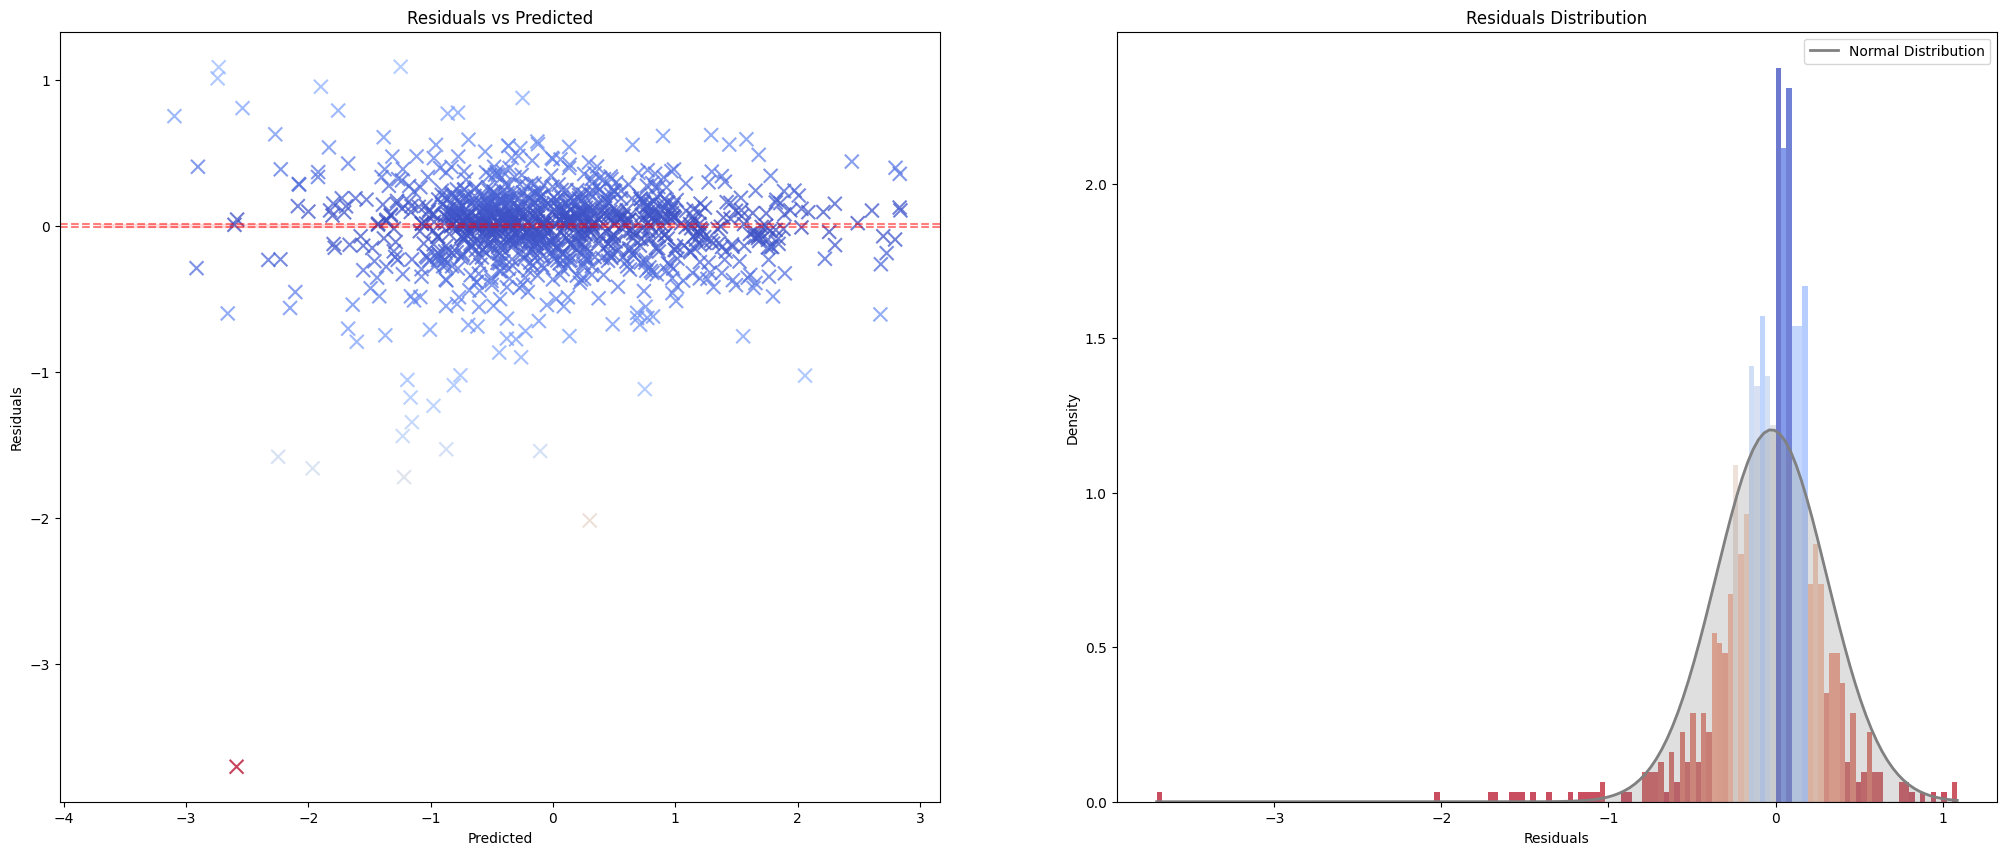

In [12]:
# Osseviamo i residui
ev.plot_residuals()